## **SEIS 631 - Create Your Own Hypothesis Test Project**


### Matt Cheney
### PGA Tour - The Impact of Driving Distance on Percent of Purse Won

> ### Test Statistic: difference in mean percent purse won
> ### Null Hypothesis: Driving distance has no impact on the percent of purse won on the PGA Tour
> ### Alternative Hypothesis: The top 25% of drivers will have a higher mean percent purse won than the bottom 25%

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [18]:

# load data
df = pd.read_csv('data/631 Project Master Data.csv')

# clean data
# change pct_purse_won to decimal where 0.0143 displays as 1.43, etc.
df['pct_purse_won'] = df['pct_purse_won'] * 100

# change player name to all lower case
df['player_name'] = df['player_name'].str.lower()
df.head()


,player_id,player_name,driver_rank,driver_avg,driver_pct_rank,driver_pct,prox_rank,prox_feet,pct_purse_won,purse_won,purse_avail
0,63343,aldrich potgieter,1,325.0,156,55.60%,163,39.0,1.43,3038146,211900000
1,28237,rory mcilroy,2,323.0,177,51.20%,154,38.4,5.65,16992418,301000000
2,52453,nicolai højgaard,3,318.8,171,53.20%,141,38.1,0.97,1897477,195300000
3,57586,jesper svensson,4,318.6,144,56.70%,150,38.3,0.54,1292826,238900000
4,48117,kurt kitayama,5,318.0,135,57.80%,5,33.9,1.36,3476376,254900000


In [7]:

# limit dataframe to just columns of interest
pga_perm = df[['player_name', 'driver_rank', 'pct_purse_won']].copy()

# calculate quartiles and filter to top 25% and bottom 25%
q75 = pga_perm['driver_rank'].quantile(0.75)
q25 = pga_perm['driver_rank'].quantile(0.25)

pga_perm = pga_perm[((pga_perm['driver_rank'] >= q75) | 
                      (pga_perm['driver_rank'] <= q25))]

# create label column for top vs bottom
pga_perm['group'] = pga_perm['driver_rank'].apply(lambda x: 'bottom' if x >= q75 else 'top')

print(f'Top 25% threshold: {q25} ranking')
print(f'Bottom 25% threshold: {q75} ranking')
print(f'Number of top drivers: {(pga_perm['group'] == 'top').sum()}')
print(f'Number of bottom drivers: {(pga_perm['group'] == 'bottom').sum()}')
print()

print(pga_perm)

Top 25% threshold: 44.0 ranking
Bottom 25% threshold: 135.25 ranking
Number of top drivers: 46
Number of bottom drivers: 45

           player_name  driver_rank  pct_purse_won   group
0    aldrich potgieter            1           1.43     top
1         rory mcilroy            2           5.65     top
2     nicolai højgaard            3           0.97     top
3      jesper svensson            4           0.54     top
4        kurt kitayama            5           1.36     top
..                 ...          ...            ...     ...
175    brandt snedeker          176           0.58  bottom
176        matt kuchar          177           0.70  bottom
177      paul peterson          178           0.44  bottom
178      andrew putnam          179           0.59  bottom
179     brian campbell          180           1.01  bottom

[91 rows x 4 columns]


In [8]:

# calculate observed difference in mean pct_purse_won
top_mean = pga_perm[pga_perm['group'] == 'top']['pct_purse_won'].mean()
bottom_mean = pga_perm[pga_perm['group'] == 'bottom']['pct_purse_won'].mean()
obs_diff = pga_perm[pga_perm['group'] == 'top']['pct_purse_won'].mean() - \
           pga_perm[pga_perm['group'] == 'bottom']['pct_purse_won'].mean()

print(top_mean)
print(bottom_mean)
print(f'Observed difference in mean percent purse won between top and bottom: {obs_diff:.4f}%')


1.0795652173913044
0.8562222222222221
Observed difference in mean percent purse won between top and bottom: 0.2233%


In [9]:

# perform permutation test
n_perm = 10000
perm_diffs = np.empty(n_perm)

for i in range(n_perm):
    pga_perm['group'] = np.random.permutation(pga_perm['group'].values)
    top_perm_mean = pga_perm[pga_perm['group'] == 'top']['pct_purse_won'].mean()
    bottom_perm_mean = pga_perm[pga_perm['group'] == 'bottom']['pct_purse_won'].mean()
    perm_diffs[i] = top_perm_mean - bottom_perm_mean

# calculate two-sided p-value
p_value = np.mean(np.abs(perm_diffs) >= np.abs(obs_diff))

print(f'Observed difference: {obs_diff:.4f}')
print(f'Permutation test p-value: {p_value:.4f}')
print()


Observed difference: 0.2233
Permutation test p-value: 0.3440



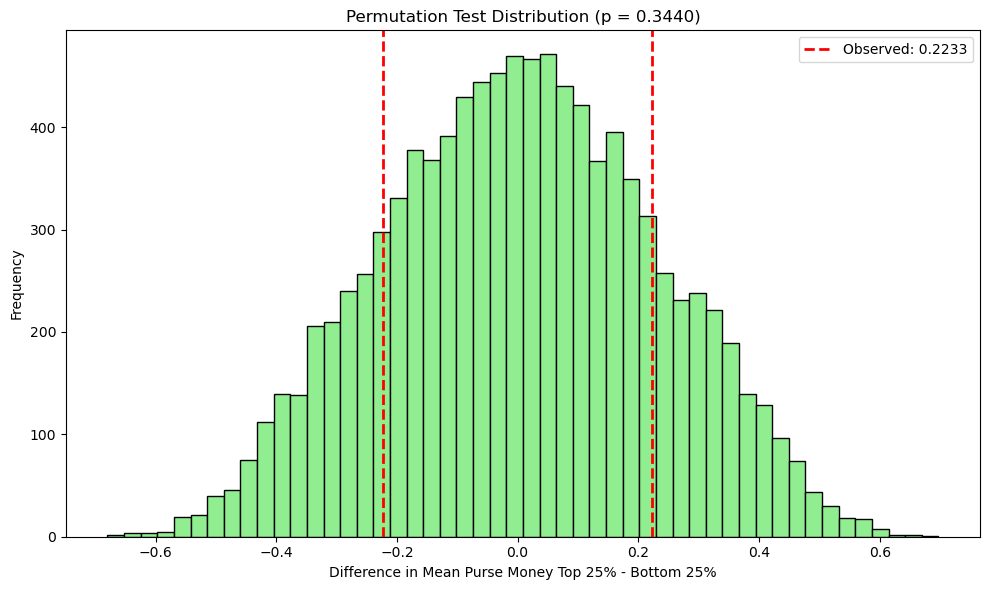

In [20]:

# permutation distribution histogram
plt.figure(figsize=(10, 6))
plt.hist(perm_diffs, bins=50, edgecolor='black', color='lightgreen')
plt.axvline(obs_diff, color='red', linestyle='--', linewidth=2, label=f'Observed: {obs_diff:.4f}')
plt.axvline(-obs_diff, color='red', linestyle='--', linewidth=2)
plt.xlabel('Difference in Mean Purse Money Top 25% - Bottom 25%')
plt.ylabel('Frequency')
plt.title(f'Permutation Test Distribution (p = {p_value:.4f})')
plt.legend()
plt.tight_layout()
plt.show()


### Our permutation test and p-value of 0.3465 tells me that we fail to reject the null hypothesis
### We cannot say that longer drivers earn more money on average than shorter drivers with statistical significance

## ==========================================

## Confidence Interval Test

> ### Use boostrapping to find a 95% confidence interval of the mean percentage purse won for each group

In [11]:
# bootstrap for CI on mean

df_ci = df.copy()

# create DFs for each quartile group
pga_boot = df_ci.copy()
q75 = pga_boot['driver_rank'].quantile(0.75)
q25 = pga_boot['driver_rank'].quantile(0.25)

pga_bottom = pga_boot[pga_boot['driver_rank'] >= q75]
pga_top = pga_boot[pga_boot['driver_rank'] <= q25]

quartile_summary = pd.DataFrame({'quartile': ['top_25', 'bottom_25']})

print(pga_bottom)


     player_id              player_name  driver_rank  driver_avg  \
135      50525          collin morikawa          136       298.3   
136      39997            corey conners          137       298.2   
137      51950             max mcgreevy          137       298.2   
138      55623             kaito onishi          137       298.2   
139      33204              shane lowry          140       298.1   
140      49960              sepp straka          141       297.9   
141      47591                eric cole          142       297.7   
142      30926               chris kirk          142       297.7   
143      51287            ryo hisatsune          144       297.5   
144      37455               si woo kim          145       297.4   
145      57900        chandler phillips          146       297.2   
146      39971               sungjae im          147       296.9   
147      33413               ben martin          148       296.7   
148      35532                 tom hoge         

In [12]:

# run bootstrap simulation for each quartile group with 95% CI on mean percent purse won
quartile_summary['boot_mean'] = pd.NA
quartile_summary['95_upper'] = pd.NA
quartile_summary['95_lower'] = pd.NA
quartile_summary['n'] = pd.NA
n = 10_000

for idx, row in quartile_summary.iterrows():
    this_quartile = row['quartile']
    
    if this_quartile == 'top_25':
        this_quartile_data = pga_top
    else:
        this_quartile_data = pga_bottom
    
    samples = []
    for i in range(n):
        boot_sample = this_quartile_data.sample(n=len(this_quartile_data), replace=True)
        samples.append(np.mean(boot_sample['pct_purse_won']))
    
    lower = np.quantile(samples, 0.025)
    upper = np.quantile(samples, 0.975)
    
    quartile_summary.at[idx, 'boot_mean'] = np.mean(samples)
    quartile_summary.at[idx, '95_lower'] = lower
    quartile_summary.at[idx, '95_upper'] = upper
    quartile_summary.at[idx, 'ci_range'] = upper - lower
    quartile_summary.at[idx, 'n'] = len(this_quartile_data)

print('Bootstrap confidence intervals for mean percent of purse won:')
print()
print(quartile_summary)
print()


Bootstrap confidence intervals for mean percent of purse won:

    quartile boot_mean 95_upper  95_lower   n  ci_range
0     top_25  1.081817  1.51481  0.757609  46  0.757201
1  bottom_25   0.85727  1.09045  0.656661  45  0.433789



> ## Because the CIs overlap, we cannot conclude a statistically significant 
> ## difference between the two groups.

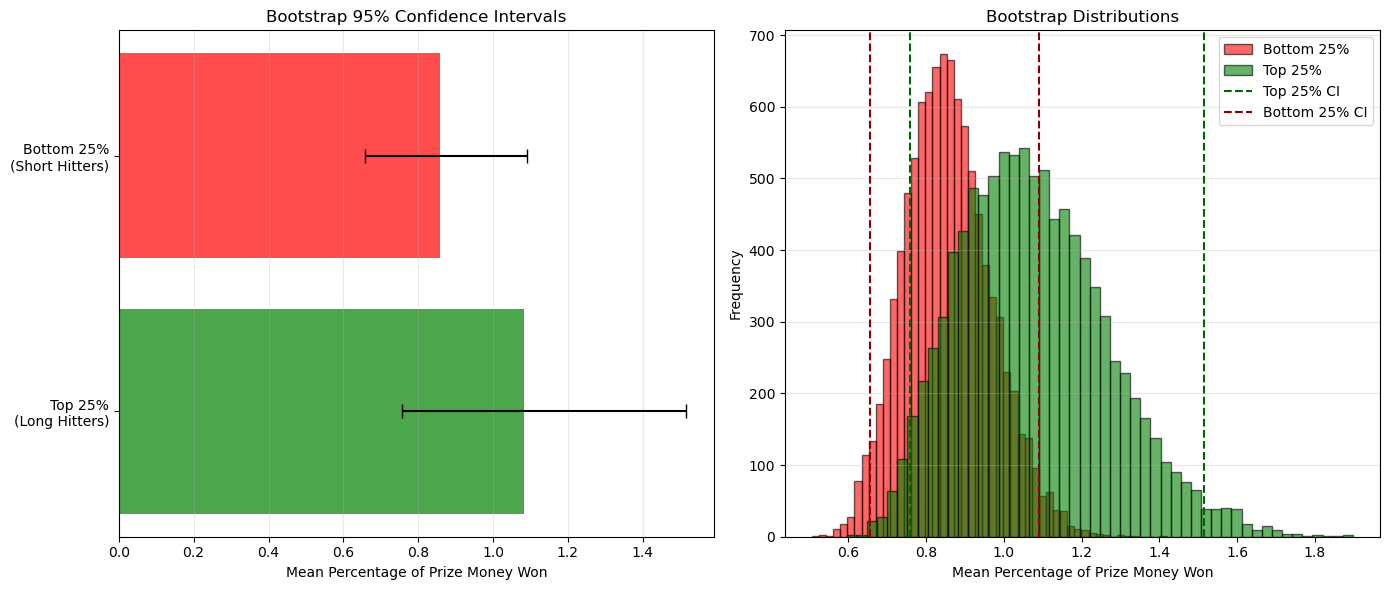

In [13]:
# visualize confidence intervals
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# plot 1: confidence interval comparison
means = quartile_summary['boot_mean'].values
errors = [means - quartile_summary['95_lower'].values, 
          quartile_summary['95_upper'].values - means]

ax1.barh([0, 1], means, xerr=errors, capsize=5, alpha=0.7, color=['green', 'red'])
ax1.set_yticks([0, 1])
ax1.set_yticklabels(['Top 25%\n(Long Hitters)', 'Bottom 25%\n(Short Hitters)'])
ax1.set_xlabel('Mean Percentage of Prize Money Won')
ax1.set_title('Bootstrap 95% Confidence Intervals')
ax1.grid(axis='x', alpha=0.3)

# plot 2: bootstrap distributions
top_samples = [np.mean(pga_top.sample(n=len(pga_top), replace=True)['pct_purse_won']) 
               for _ in range(n)]
bottom_samples = [np.mean(pga_bottom.sample(n=len(pga_bottom), replace=True)['pct_purse_won']) 
                  for _ in range(n)]

ax2.hist(bottom_samples, bins=50, alpha=0.6, color='red', label='Bottom 25%', edgecolor='black')
ax2.hist(top_samples, bins=50, alpha=0.6, color='green', label='Top 25%', edgecolor='black')

# add confidence interval lines
top_ci = quartile_summary[quartile_summary['quartile'] == 'top_25'][['95_lower', '95_upper']].values[0]
bottom_ci = quartile_summary[quartile_summary['quartile'] == 'bottom_25'][['95_lower', '95_upper']].values[0]

ax2.axvline(top_ci[0], color='darkgreen', linestyle='--', linewidth=1.5)
ax2.axvline(top_ci[1], color='darkgreen', linestyle='--', linewidth=1.5, label='Top 25% CI')
ax2.axvline(bottom_ci[0], color='darkred', linestyle='--', linewidth=1.5)
ax2.axvline(bottom_ci[1], color='darkred', linestyle='--', linewidth=1.5, label='Bottom 25% CI')

ax2.set_xlabel('Mean Percentage of Prize Money Won')
ax2.set_ylabel('Frequency')
ax2.set_title('Bootstrap Distributions')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## ===============================================

## CI on Max Percent Purse Won (rather than mean)

In [14]:


# bootstrap for CI on mean

df_ci_max = df.copy()

# create DFs for each quartile group
pga_boot_max = df_ci_max.copy()
q75_max = pga_boot_max['driver_rank'].quantile(0.75)
q25_max = pga_boot_max['driver_rank'].quantile(0.25)

pga_bottom_max = pga_boot_max[pga_boot_max['driver_rank'] >= q75_max]
pga_top_max = pga_boot_max[pga_boot_max['driver_rank'] <= q25_max]

quartile_summary_max = pd.DataFrame({'quartile': ['top_25', 'bottom_25']})

print(pga_bottom_max)


# run bootstrap simulation for each quartile group with 95% CI
quartile_summary_max['boot_max'] = pd.NA
quartile_summary_max['95_upper'] = pd.NA
quartile_summary_max['95_lower'] = pd.NA
quartile_summary_max['n'] = pd.NA
n = 10_000

for idx, row in quartile_summary_max.iterrows():
    this_quartile = row['quartile']
    
    if this_quartile == 'top_25':
        this_quartile_data = pga_top_max
    else:
        this_quartile_data = pga_bottom_max
    
    samples = []
    for i in range(n):
        boot_sample = this_quartile_data.sample(n=len(this_quartile_data), replace=True)
        samples.append(boot_sample['pct_purse_won'].max())
    
    lower = np.quantile(samples, 0.025)
    upper = np.quantile(samples, 0.975)
    
    quartile_summary_max.at[idx, 'boot_max'] = np.mean(samples)
    quartile_summary_max.at[idx, '95_lower'] = lower
    quartile_summary_max.at[idx, '95_upper'] = upper
    quartile_summary_max.at[idx, 'ci_range'] = upper - lower
    quartile_summary_max.at[idx, 'n'] = len(this_quartile_data)


print('Bootstrap confidence interval for max of purse won in the two groups:')
print()
print(quartile_summary_max)
print()



     player_id              player_name  driver_rank  driver_avg  \
135      50525          collin morikawa          136       298.3   
136      39997            corey conners          137       298.2   
137      51950             max mcgreevy          137       298.2   
138      55623             kaito onishi          137       298.2   
139      33204              shane lowry          140       298.1   
140      49960              sepp straka          141       297.9   
141      47591                eric cole          142       297.7   
142      30926               chris kirk          142       297.7   
143      51287            ryo hisatsune          144       297.5   
144      37455               si woo kim          145       297.4   
145      57900        chandler phillips          146       297.2   
146      39971               sungjae im          147       296.9   
147      33413               ben martin          148       296.7   
148      35532                 tom hoge         

In [15]:


# check if confidence intervals overlap
top_lower_max = quartile_summary_max[quartile_summary_max['quartile'] == 'top_25']['95_lower'].values[0]
bottom_upper_max = quartile_summary_max[quartile_summary_max['quartile'] == 'bottom_25']['95_upper'].values[0]

print('Bootstrap confidence intervals for mean percent of purse won:')
print()
print(quartile_summary_max)
print()



Bootstrap confidence intervals for mean percent of purse won:

    quartile  boot_max 95_upper 95_lower   n  ci_range
0     top_25  6.537793     7.76     2.08  46      5.68
1  bottom_25  3.464966      4.0     2.05  45      1.95



> ## Because the CIs overlap, we cannot conclude a statistically significant 
> ## difference between the two groups.

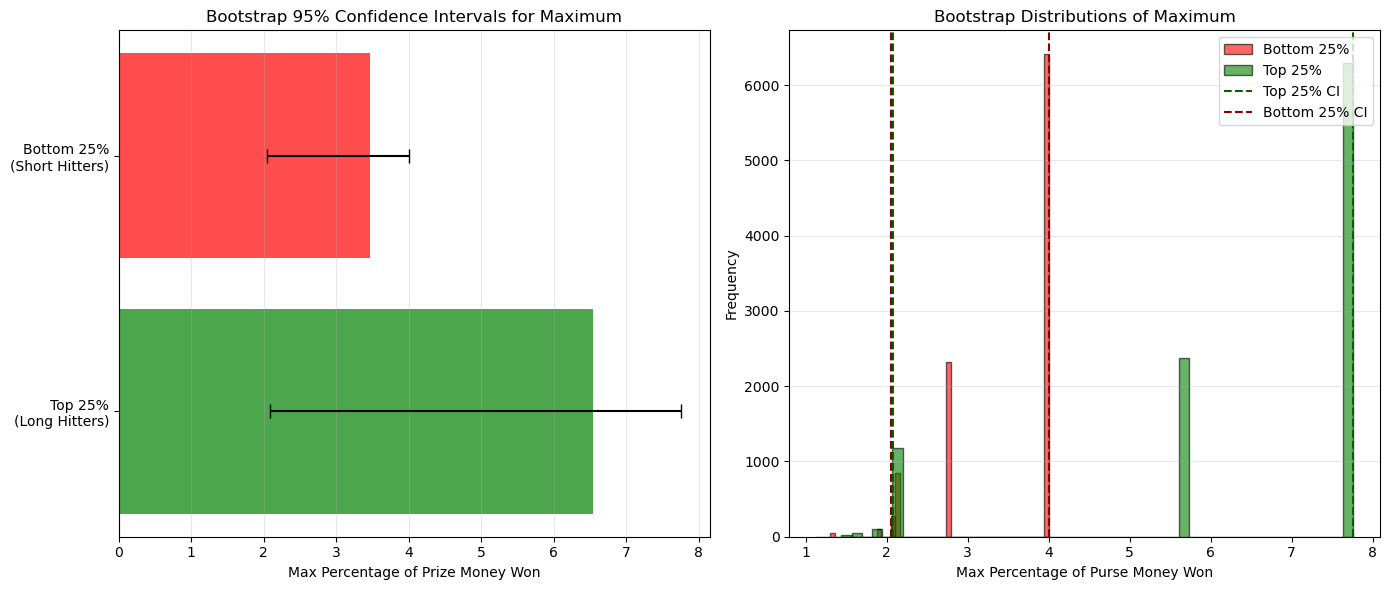

In [16]:
# visualize the confidence intervals
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# plot 1: confidence interval comparison
means_max = quartile_summary_max['boot_max'].values
errors = [means_max - quartile_summary_max['95_lower'].values, 
          quartile_summary_max['95_upper'].values - means_max]

ax1.barh([0, 1], means_max, xerr=errors, capsize=5, alpha=0.7, color=['green', 'red'])
ax1.set_yticks([0, 1])
ax1.set_yticklabels(['Top 25%\n(Long Hitters)', 'Bottom 25%\n(Short Hitters)'])
ax1.set_xlabel('Max Percentage of Prize Money Won')
ax1.set_title('Bootstrap 95% Confidence Intervals for Maximum')
ax1.grid(axis='x', alpha=0.3)

# plot 2: bootstrap distributions
top_samples_max = []
bottom_samples_max = []

for i in range(10000):
    top_boot = pga_top_max.sample(n=len(pga_top_max), replace=True)
    bottom_boot = pga_bottom_max.sample(n=len(pga_bottom_max), replace=True)
    top_samples_max.append(top_boot['pct_purse_won'].max())
    bottom_samples_max.append(bottom_boot['pct_purse_won'].max())

ax2.hist(bottom_samples_max, bins=50, alpha=0.6, color='red', label='Bottom 25%', edgecolor='black')
ax2.hist(top_samples_max, bins=50, alpha=0.6, color='green', label='Top 25%', edgecolor='black')

# add confidence interval lines
top_ci_max = quartile_summary_max[quartile_summary_max['quartile'] == 'top_25'][['95_lower', '95_upper']].values[0]
bottom_ci_max = quartile_summary_max[quartile_summary_max['quartile'] == 'bottom_25'][['95_lower', '95_upper']].values[0]

ax2.axvline(top_ci_max[0], color='darkgreen', linestyle='--', linewidth=1.5)
ax2.axvline(top_ci_max[1], color='darkgreen', linestyle='--', linewidth=1.5, label='Top 25% CI')
ax2.axvline(bottom_ci_max[0], color='darkred', linestyle='--', linewidth=1.5)
ax2.axvline(bottom_ci_max[1], color='darkred', linestyle='--', linewidth=1.5, label='Bottom 25% CI')

ax2.set_xlabel('Max Percentage of Purse Money Won')
ax2.set_ylabel('Frequency')
ax2.set_title('Bootstrap Distributions of Maximum')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [17]:
print(f'Top 25% actual max: {pga_top_max['pct_purse_won'].max():.4f}')
print(f'Bottom 25% actual max: {pga_bottom_max['pct_purse_won'].max():.4f}')
print(f'\nTop samples range: {min(top_samples_max):.4f} to {max(top_samples_max):.4f}')
print(f'Bottom samples range: {min(bottom_samples_max):.4f} to {max(bottom_samples_max):.4f}')


Top 25% actual max: 7.7600
Bottom 25% actual max: 4.0000

Top samples range: 1.4400 to 7.7600
Bottom samples range: 1.1300 to 4.0000


> ## Because the CIs overlap, we cannot conclude a statistically significant 
> ## difference between the two groups.